In [ ]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import preamble
from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED

In [399]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


In [241]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# PCA Analyisis

In [291]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(np.stack(df[EMBEDDING_MODEL]))

reduced_embeddings = pca.transform(np.stack(df[EMBEDDING_MODEL]))


In [292]:
pca.explained_variance_ratio_.sum()

np.float32(0.09815486)

PCA doesn't explain much variance 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

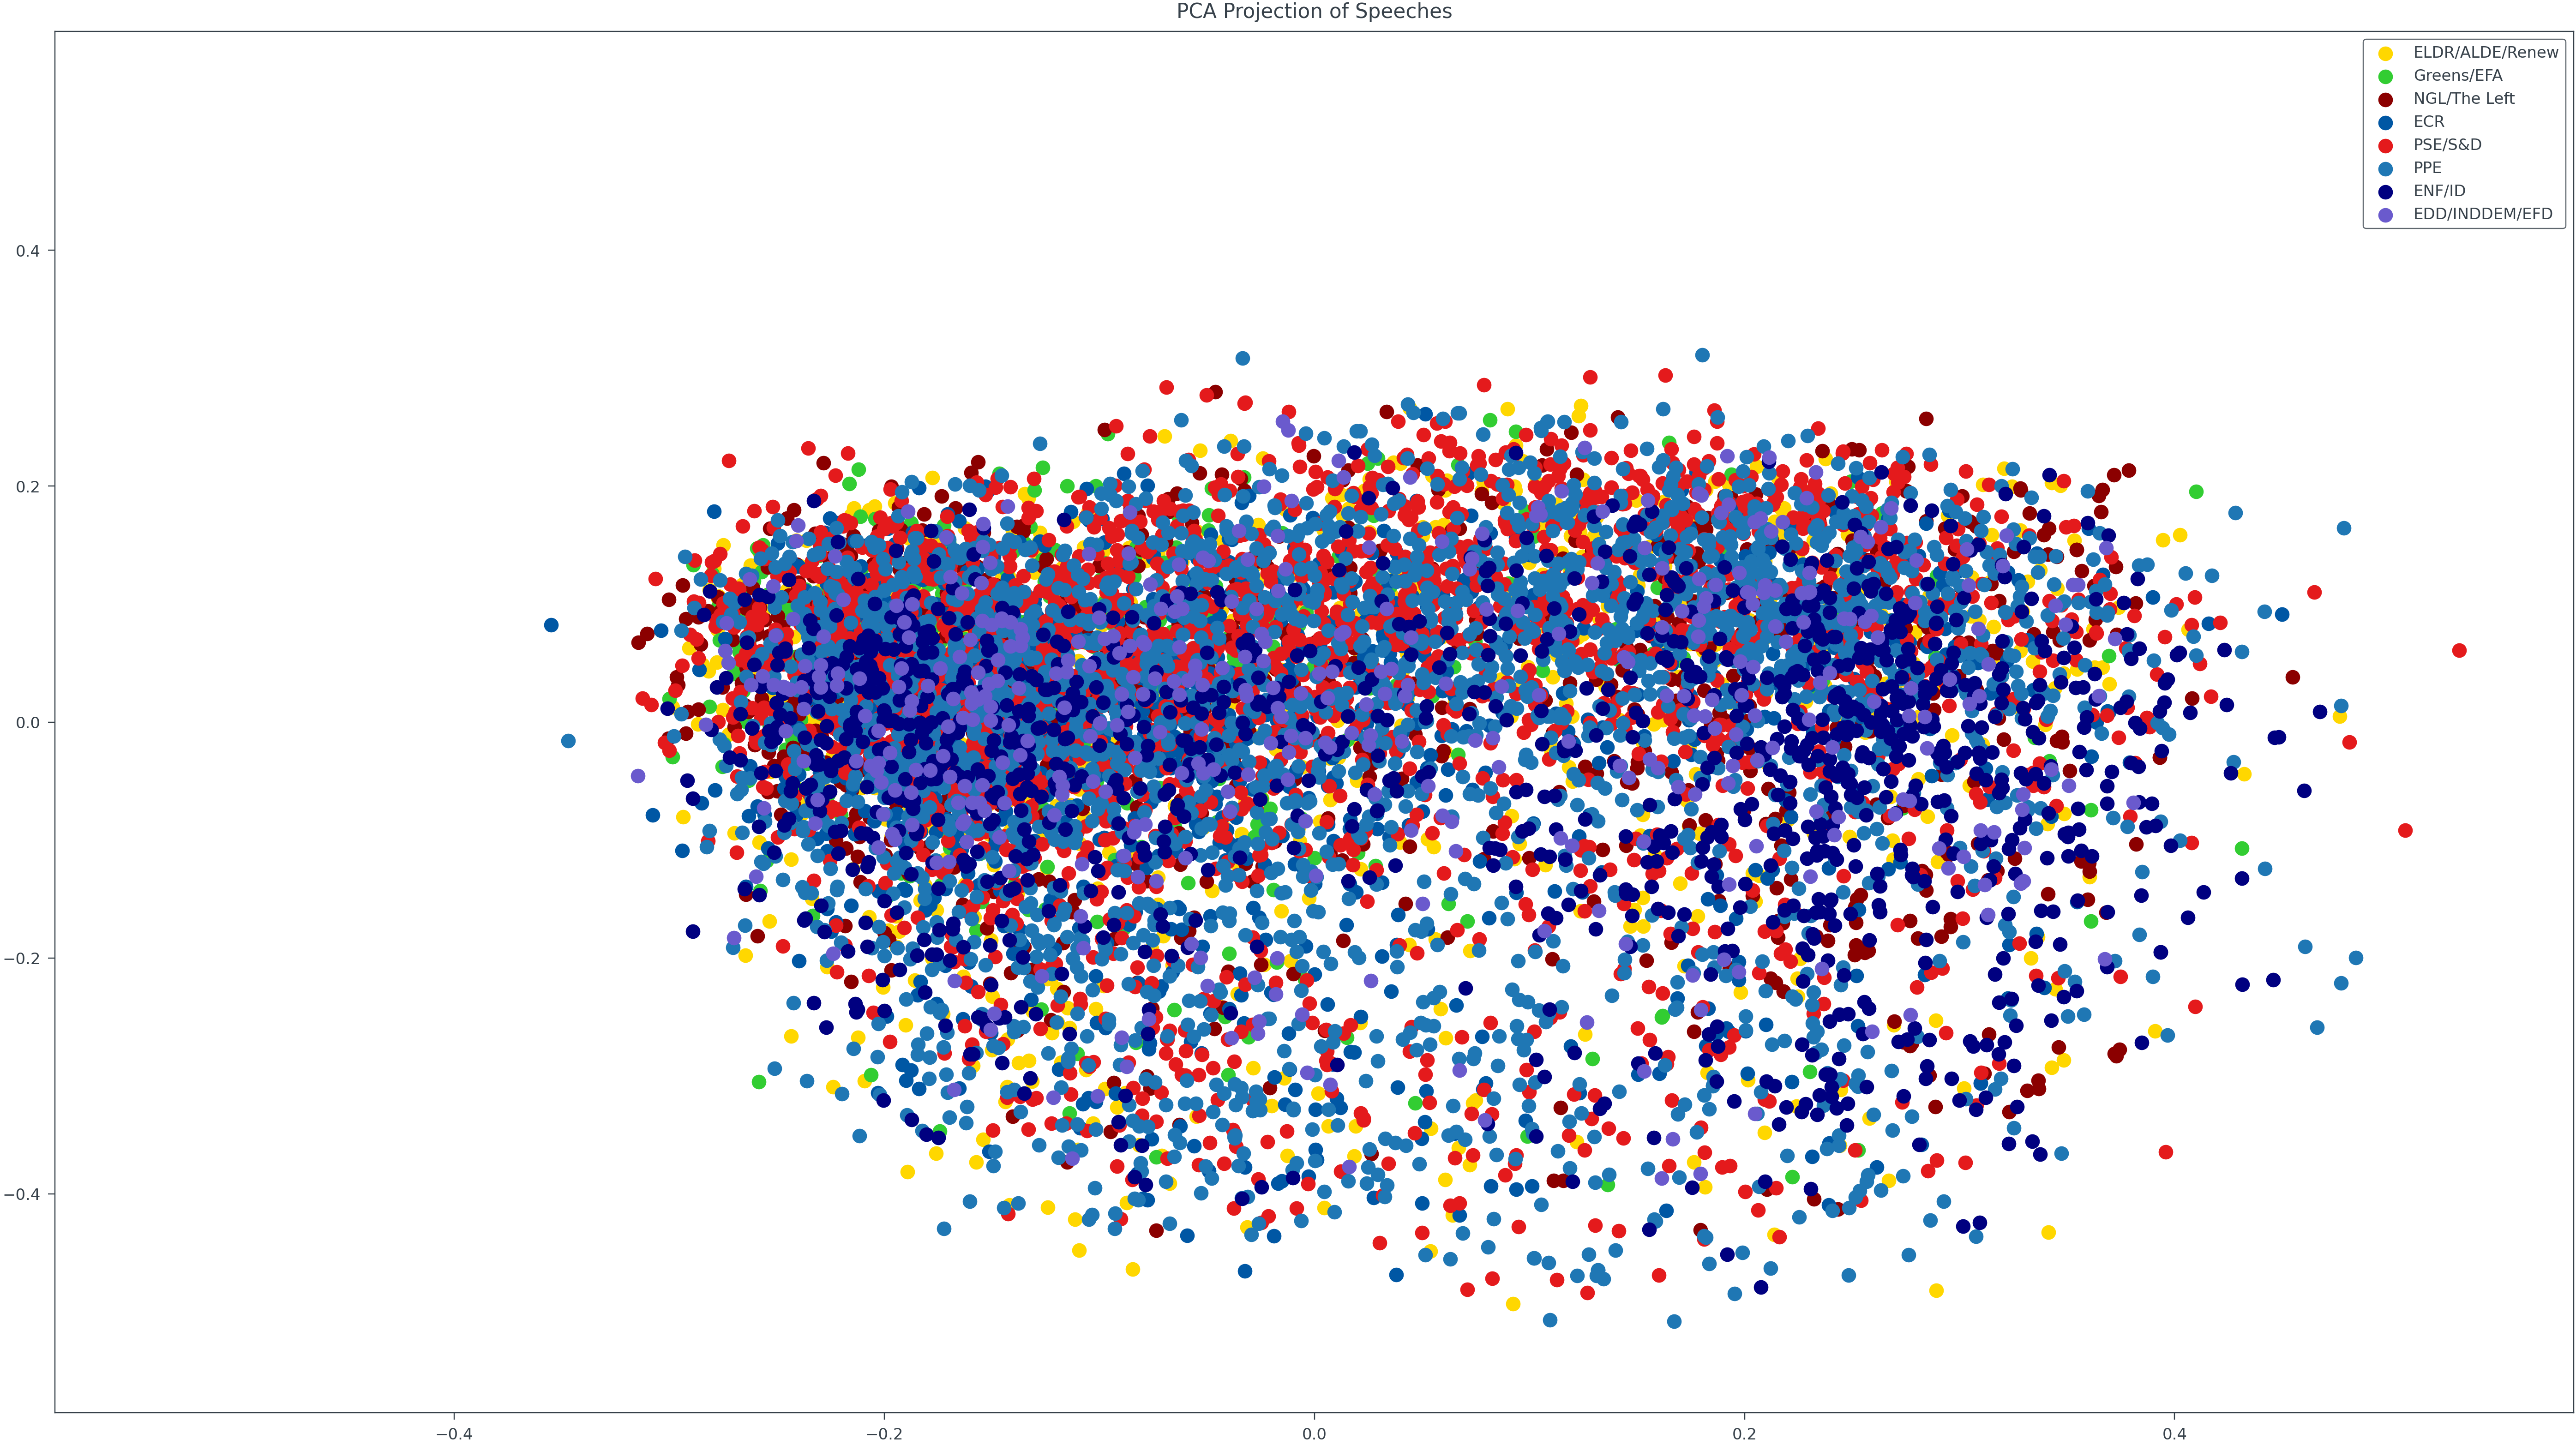

In [293]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
plt.title("PCA Projection of Speeches")

grt = np.abs(reduced_embeddings).max() * 1.1

ax.set_xlim(-grt, grt)
ax.set_ylim(-grt, grt)
scale = grt * 2


for party in df["party"].unique():
    party_mask = df["party"] == party
    party_embeddings = reduced_embeddings[party_mask]
    
    plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=COLOR_MAPS['party'][party], label=party)

ax.legend()

No Apparent pattern visible. But we can try to interpret what this axis by looking at the words that have embeddings closest to the extreme points on the graphs

In [368]:
# Transform vocab embeddings
vocab_embeddings = pca.transform(np.stack(vocab_df[EMBEDDING_MODEL]))

# normalize and get axis 0 extreme examples
normalized_vocab_emb = vocab_embeddings / np.linalg.norm(vocab_embeddings, ord=2, axis=1, keepdims=True)
sorted_indicies = normalized_vocab_emb[:, 0].argsort()

In [369]:
vocab_df['word'].iloc[sorted_indicies[: 20]]

21007                        rede
18586                    speeches
20642                 präsidentin
5091                   presidenta
18196                  presidents
6557                   présidente
13648                presidencies
6531                  presidencys
9952                   presidenza
10635    παπαδημουλησαντιπρόεδρος
7467                   presidente
19840                      preach
7478                    president
17523                      señora
6539                      geachte
15719                      speech
12761                    προεδρια
8038                     preaches
19507           presidentinoffice
15556           presidentdictator
Name: word, dtype: object

In [370]:
def closest_words_for_pc(k, model, vocab, probe_embs, top_n=20):
    reduced = model.transform(probe_embs)

    reduced = reduced / np.linalg.vector_norm(reduced, ord=2, axis=1, keepdims=True)
    
    sorted_indices = np.argsort(reduced[:, k])
    pos_idx = sorted_indices[-top_n:]

    neg_idx = sorted_indices[:top_n]
    

    def map_indices_to_examples(index_list): 
        if isinstance(vocab, pd.DataFrame) or isinstance(vocab, pd.Series): 
            return [(vocab.iloc[i], reduced[:, k][i]) for i in index_list]
        else:
            return [(vocab[i], reduced[:, k][i]) for i in index_list]

    return map_indices_to_examples(neg_idx),  map_indices_to_examples(pos_idx)


In [371]:
axis_labels_0 = closest_words_for_pc(0, pca, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pca, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [372]:
axis_labels_0

([('rede', np.float32(-0.94296324)),
  ('speeches', np.float32(-0.926397)),
  ('präsidentin', np.float32(-0.87396765)),
  ('presidenta', np.float32(-0.8267069)),
  ('presidents', np.float32(-0.77351964)),
  ('présidente', np.float32(-0.76342)),
  ('presidencies', np.float32(-0.7293562)),
  ('presidencys', np.float32(-0.69253284)),
  ('presidenza', np.float32(-0.664824)),
  ('παπαδημουλησαντιπρόεδρος', np.float32(-0.62593)),
  ('presidente', np.float32(-0.6158435)),
  ('preach', np.float32(-0.54955834)),
  ('president', np.float32(-0.53812224)),
  ('señora', np.float32(-0.4786128)),
  ('geachte', np.float32(-0.43563098)),
  ('speech', np.float32(-0.4166657)),
  ('προεδρια', np.float32(-0.41212666)),
  ('preaches', np.float32(-0.38976598)),
  ('presidentinoffice', np.float32(-0.3787132)),
  ('presidentdictator', np.float32(-0.30590513))],
 [('readmissions', np.float32(0.9999944)),
  ('totalled', np.float32(0.99999493)),
  ('reshuffled', np.float32(0.9999952)),
  ('livelihood', np.float32

In [373]:
from IPython.display import display, HTML

def display_axis_semantics(axis_words: list[tuple[list[str]]]) -> None:
    data = []
    for axis, pairs in enumerate(axis_words):
        data.append({"Axis": axis, "Direction": "Neg", "Words": ", ".join([elem[0] for elem in pairs[0]])})
        data.append({"Axis": axis, "Direction": "Pos", "Words": ", ".join([elem[0] for elem in pairs[1]])})

    df = pd.DataFrame(data).set_index(["Axis", "Direction"])
    df['Words'] = df['Words'].str.wrap(100)
    display(HTML(df.to_html().replace("\\n","<br>")))

In [374]:
display_axis_semantics([axis_labels_0, axis_labels_1])

In [375]:
normalized_embeddings = reduced_embeddings / np.linalg.vector_norm(reduced_embeddings, ord=2, axis=1, keepdims=True)

In [376]:
# get extreme example speeches
neg_0 = df['translatedText'].iloc[normalized_embeddings[:, 0].argmin().item()]
pos_0 = df['translatedText'].iloc[normalized_embeddings[:, 0].argmax().item()]
neg_1 = df['translatedText'].iloc[normalized_embeddings[:, 1].argmin().item()]
pos_1 = df['translatedText'].iloc[normalized_embeddings[:, 1].argmax().item()]

In [377]:
import textwrap
print(textwrap.fill(pos_0))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_0[1]])))

Solidarity Funding is an aspect of cross-border support which
demonstrates the EU’s core values. This is the kind of solidarity that
the UK has benefited from in its more than 40 years of EU membership.
Labour MEPs will continue to stand up for our common European values
of solidarity across borders, tolerance, openness and dialogue.
Closest Words:
readmissions, totalled, reshuffled, livelihood, hushed, battered,
leftleaning, lefts, apologize, children, raising, subsidise,
redistributions, relegated, unsustainable, mafiosi, proportions,
uprising, resurgent, conflict


In [335]:
print(textwrap.fill(neg_0))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_0[0]])))

We are still working hard on the Turkey deal and today we are already
talking about a new deal, a deal with countries in Africa. A new deal
in which the European Commission and the Member States are trying to
prevent deaths at sea and manage migration. The big mistake we made
with Turkey is repeating itself. The flaw is that we don't say:
"Africa, African countries, we see your problems. How can we help
you?" But that we say: "We, we in Europe, we have screaming populists
and that is why we want to stop migration." Everything seems to be
aimed at holding refugees back instead of helping them. And if we look
at the figures, I wonder whether your proposals are achieving their
goals. This year, more people have died in the same period than a year
ago. How is that possible? And why would your proposals solve this?
There have not been more migrants who have made the crossing, but
there have been more who have had to pay for it with their lives.
Isn't there simply something wrong with how we

In [378]:
print(textwrap.fill(pos_1))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_1[1]])))

The flow of refugees and migrants has reached an unprecedented scale.
This international crisis needs an international response. In order to
cope with the current situation, the European Union needs to support
Syria and its direct neighbours as well as the Western Balkans. I
welcome that already EUR 4 billion in EU and Member States funding
have been spent to help Syria and its neighbours. Turkey is one of the
key countries in the region. The European Union’s support for Turkey,
a country that has already received 2 million refugees, needs to be
stepped up. Most refugees enter the European Union via the Western
Balkan route. Therefore, countries like Serbia are not part of the
problem, but part of the solution. Commissioner Johannes Hahn is right
when he states that the Western Balkans must ‘not become a parking
lot’ for stranded refugees. I welcome that the European Commission has
increased the migration-related assistance for Serbia and the former
Yugoslav Republic of Macedonia. Stab

In [379]:
print(textwrap.fill(neg_1))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_1[0]])))

Mr. MP, you questioned the importance of protecting external borders
and pursued German policy within. If we were to abandon strict
external border protection, what would be the remedy? What exactly are
you proposing, because you have criticized others, but I have not
heard any positive response from socialists. What is the message, what
is the socialist response to this problem?
Closest Words:
presidency, papadimoulisvicepresident, spoke, chairwoman, madame,
message, vizepräsidentin, monsieur, presides, presenters, speaking,
signor, speak, vorsitz, lectures, lady, discourses, greet,
vicepresidentquestions, unceremoniously


In [338]:
def get_extreme_example_texts(df: pd.DataFrame, normalized_embeddings: np.array):
    neg_0 = df['translatedText'].iloc[normalized_embeddings[:, 0].argmin().item()]
    pos_0 = df['translatedText'].iloc[normalized_embeddings[:, 0].argmax().item()]
    neg_1 = df['translatedText'].iloc[normalized_embeddings[:, 1].argmin().item()]
    pos_1 = df['translatedText'].iloc[normalized_embeddings[:, 1].argmax().item()]

    return neg_0, pos_0, neg_1, pos_1

In [339]:
(sum([label[0] in neg_1  for label in axis_labels_1[0]]), 
sum([label[0] in pos_1  for label in axis_labels_1[1]]), 
sum([label[0] in neg_0  for label in axis_labels_0[0]]),
sum([label[0] in pos_0  for label in axis_labels_0[1]]))

(1, 2, 0, 0)

terms themselves are mostly not present in our examples so we can assume that it isn't picking on rare words but on some underlying ideas

In [330]:
def get_extreme_examples(df: pd.DataFrame, normalized_embeddings: np.array):
    return df.iloc[[normalized_embeddings[:, 0].argmin().item(),
                     normalized_embeddings[:, 0].argmax().item(),
                    normalized_embeddings[:, 1].argmin().item(),
                     normalized_embeddings[:, 1].argmax().item()]]

In [331]:
examples = get_extreme_examples(df, normalized_embeddings)
reduced_examples = pca.transform(np.stack(examples[EMBEDDING_MODEL]))

(2,)
(2,)
(2,)
(2,)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

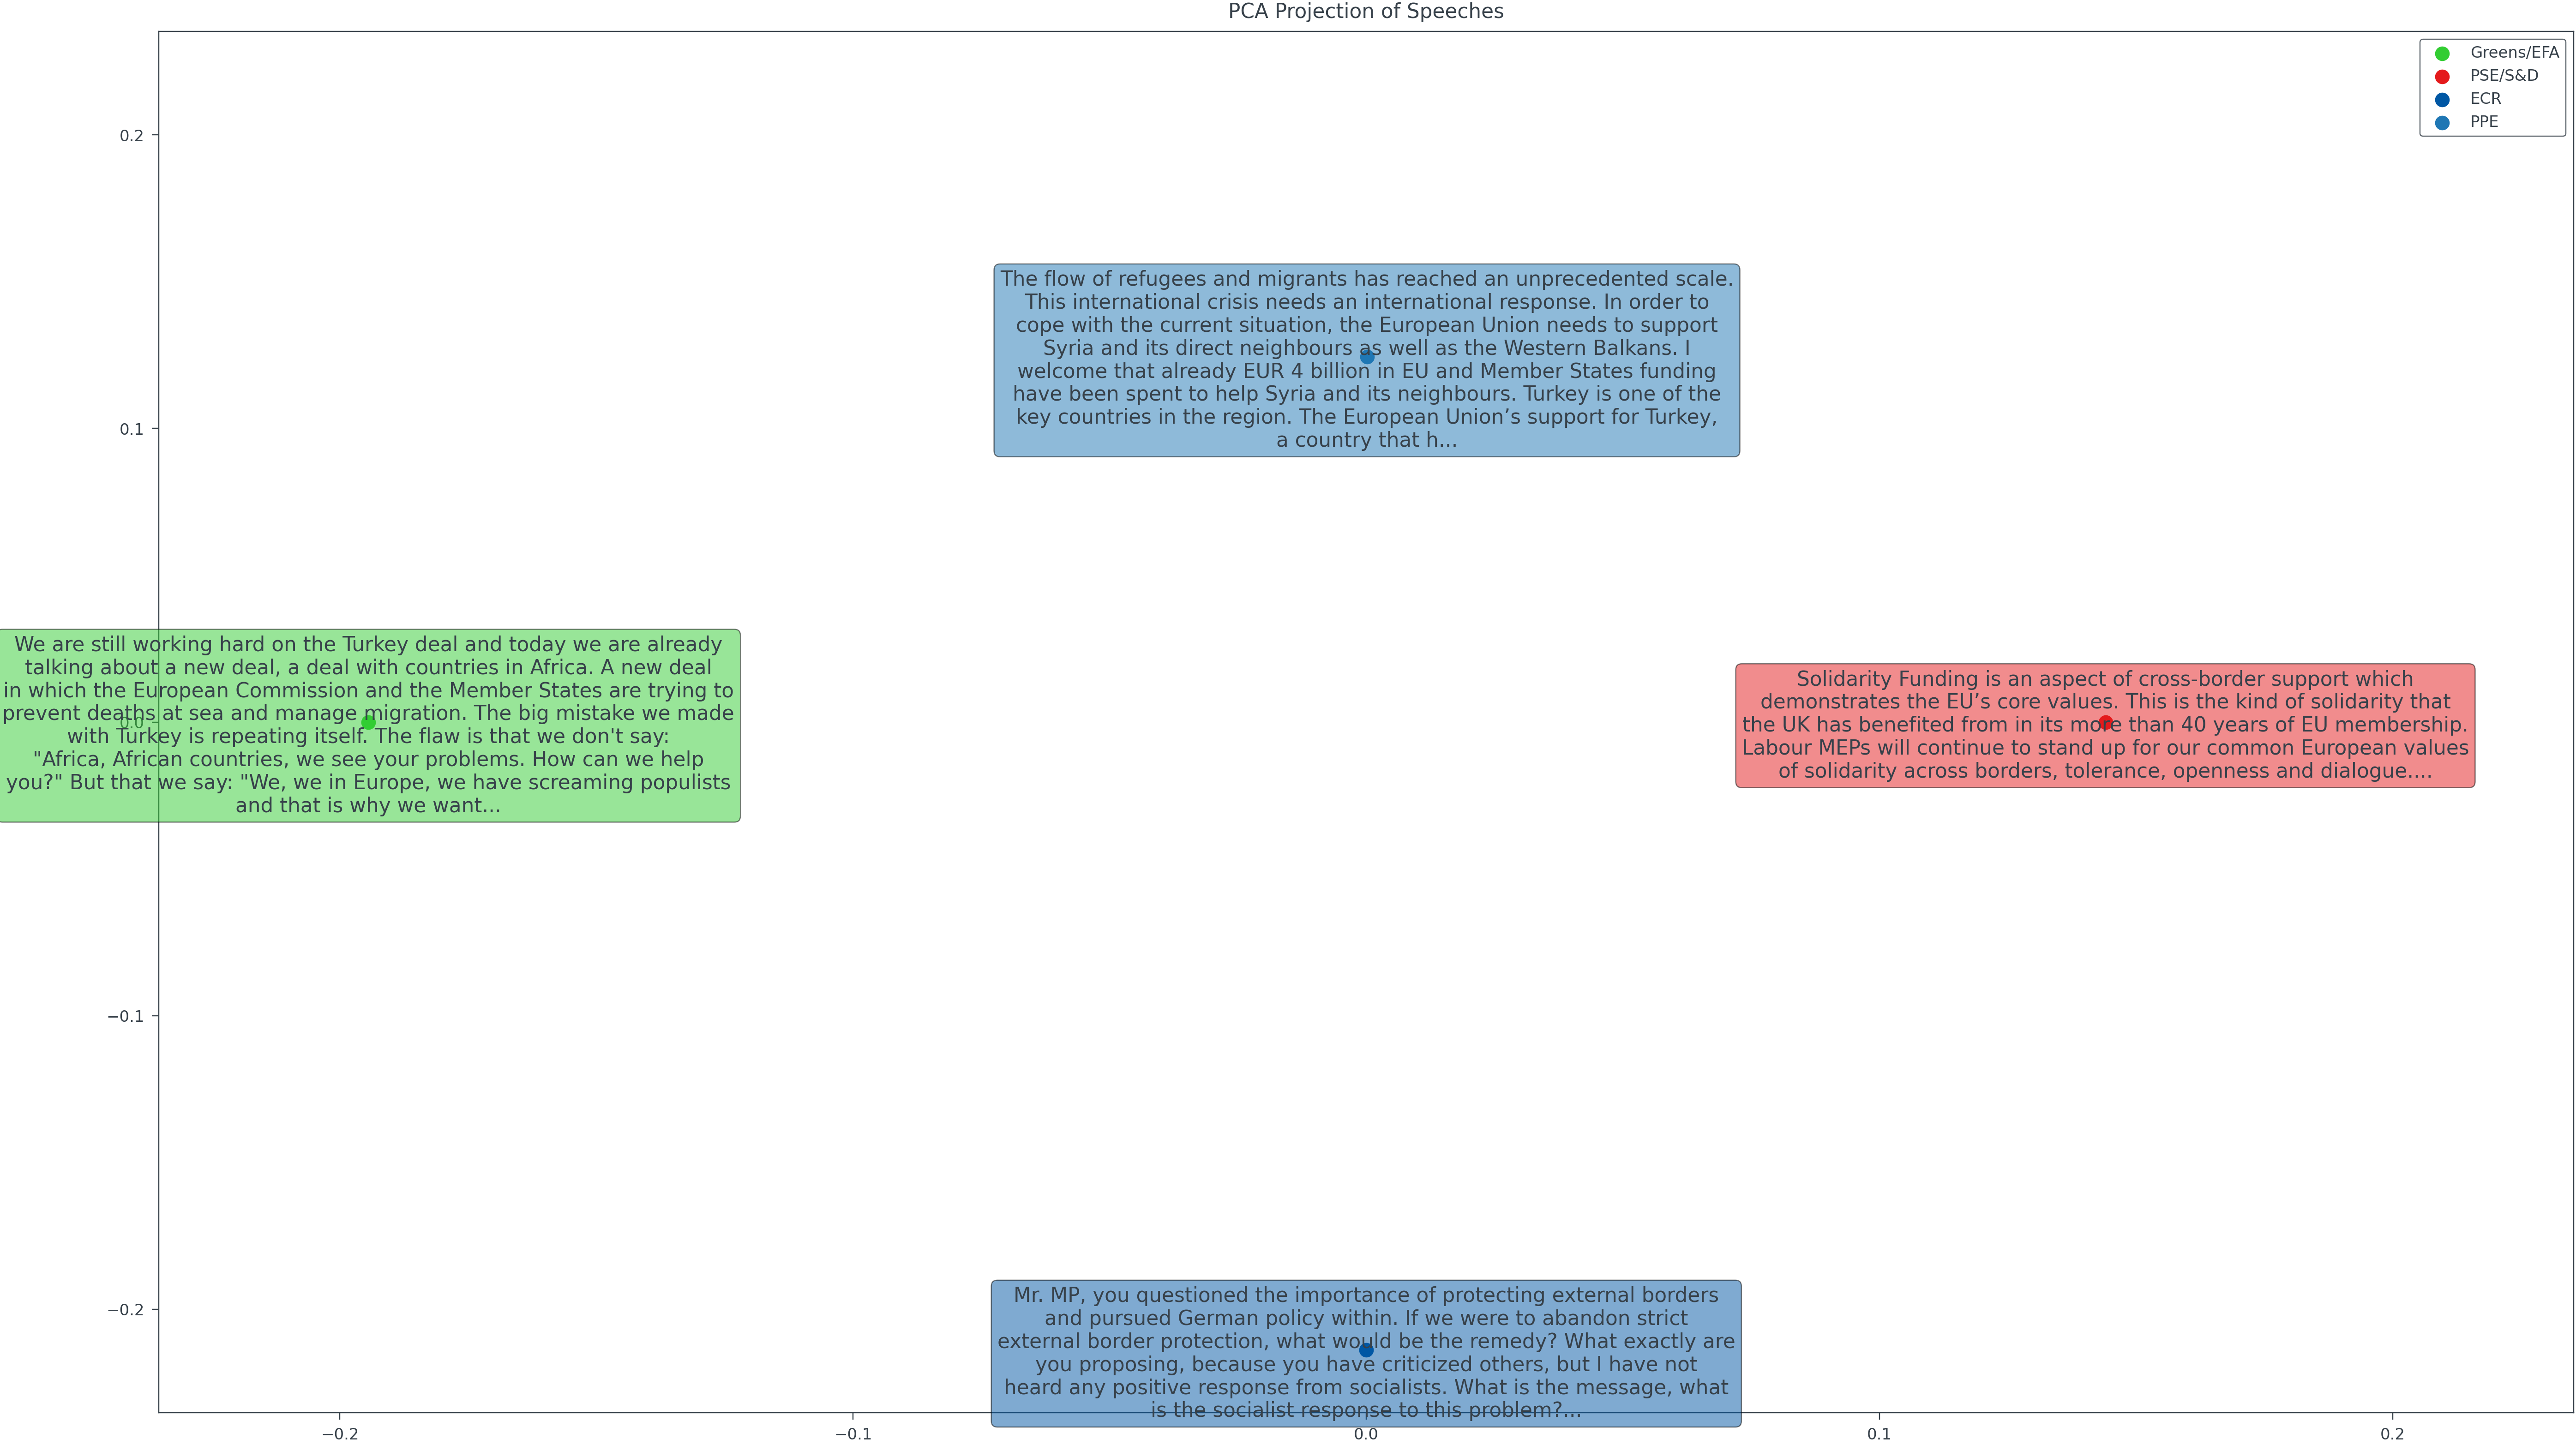

In [381]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
plt.title("PCA Projection of Speeches")

grt = np.abs(reduced_examples).max() * 1.1

ax.set_xlim(-grt, grt)
ax.set_ylim(-grt, grt)
scale = grt * 2



for party in examples["party"].unique():
    party_mask = examples["party"] == party
    party_embeddings = reduced_examples[party_mask]


    for idx, party_emb in enumerate(party_embeddings):
        print(party_emb.shape)

        props = dict(boxstyle='round', facecolor=COLOR_MAPS['party'][party], alpha=0.5)
        ax.text(party_emb[0], party_emb[1], s=textwrap.fill(examples[party_mask].iloc[idx]['translatedText'][:500] + "..."),
                verticalalignment='center_baseline', horizontalalignment="center",
                bbox=props)
    
    plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=COLOR_MAPS['party'][party], label=party)

ax.legend()

# Finding PCA Axis

Axis with highest variance might not be what we want we can try Principal Component Regression and identify PCs which have highest predictive power of our target variable. What we want to do is identify how parties differ and we can do that by finding hyperplane in the vector space which can identify and help us see this differences

## Party as target var

In [382]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder




X = np.stack(df[EMBEDDING_MODEL])

lb = LabelEncoder()
y = lb.fit_transform(df["party"])

print(f"#Classes {len(lb.classes_)}")


#Classes 8


In [383]:
N_PCS = 100
pca = PCA(n_components=N_PCS)
X_pca =  pca.fit_transform(X)
pca.explained_variance_ratio_.sum()

np.float32(0.7025026)

In [384]:
from tqdm import tqdm


results = np.zeros((N_PCS, N_PCS))

for pc_1 in tqdm(range(N_PCS)):
    for pc_2 in range(pc_1 + 1, N_PCS):
        pcr = LogisticRegression()
        pcr.fit(X_pca[:, [pc_1, pc_2]], y)
        results[pc_1, pc_2] = pcr.score(X_pca[:, [pc_1, pc_2]], y) 



100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


In [385]:
pcs = np.unravel_index(results.argmax(), shape=(N_PCS, N_PCS))
print(f"PCA axis: {pcs}")

PCA axis: (np.int64(2), np.int64(5))


## Block as target var

In [386]:
lb = LabelEncoder()
y = lb.fit_transform(df["block"])

print(f"#Classes {len(lb.classes_)}")

results = np.zeros((N_PCS, N_PCS))

for pc_1 in tqdm(range(N_PCS)):
    for pc_2 in range(pc_1 + 1, N_PCS):
        pcr = LogisticRegression()
        pcr.fit(X_pca[:, [pc_1, pc_2]], y)
        results[pc_1, pc_2] = pcr.score(X_pca[:, [pc_1, pc_2]], y) 

#Classes 6


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [387]:
pcs = np.unravel_index(results.argmax(), shape=(N_PCS, N_PCS))
print(f"PCA axis: {pcs}")

PCA axis: (np.int64(2), np.int64(5))


In [388]:
reduced_embeddings = X_pca[:, pcs]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

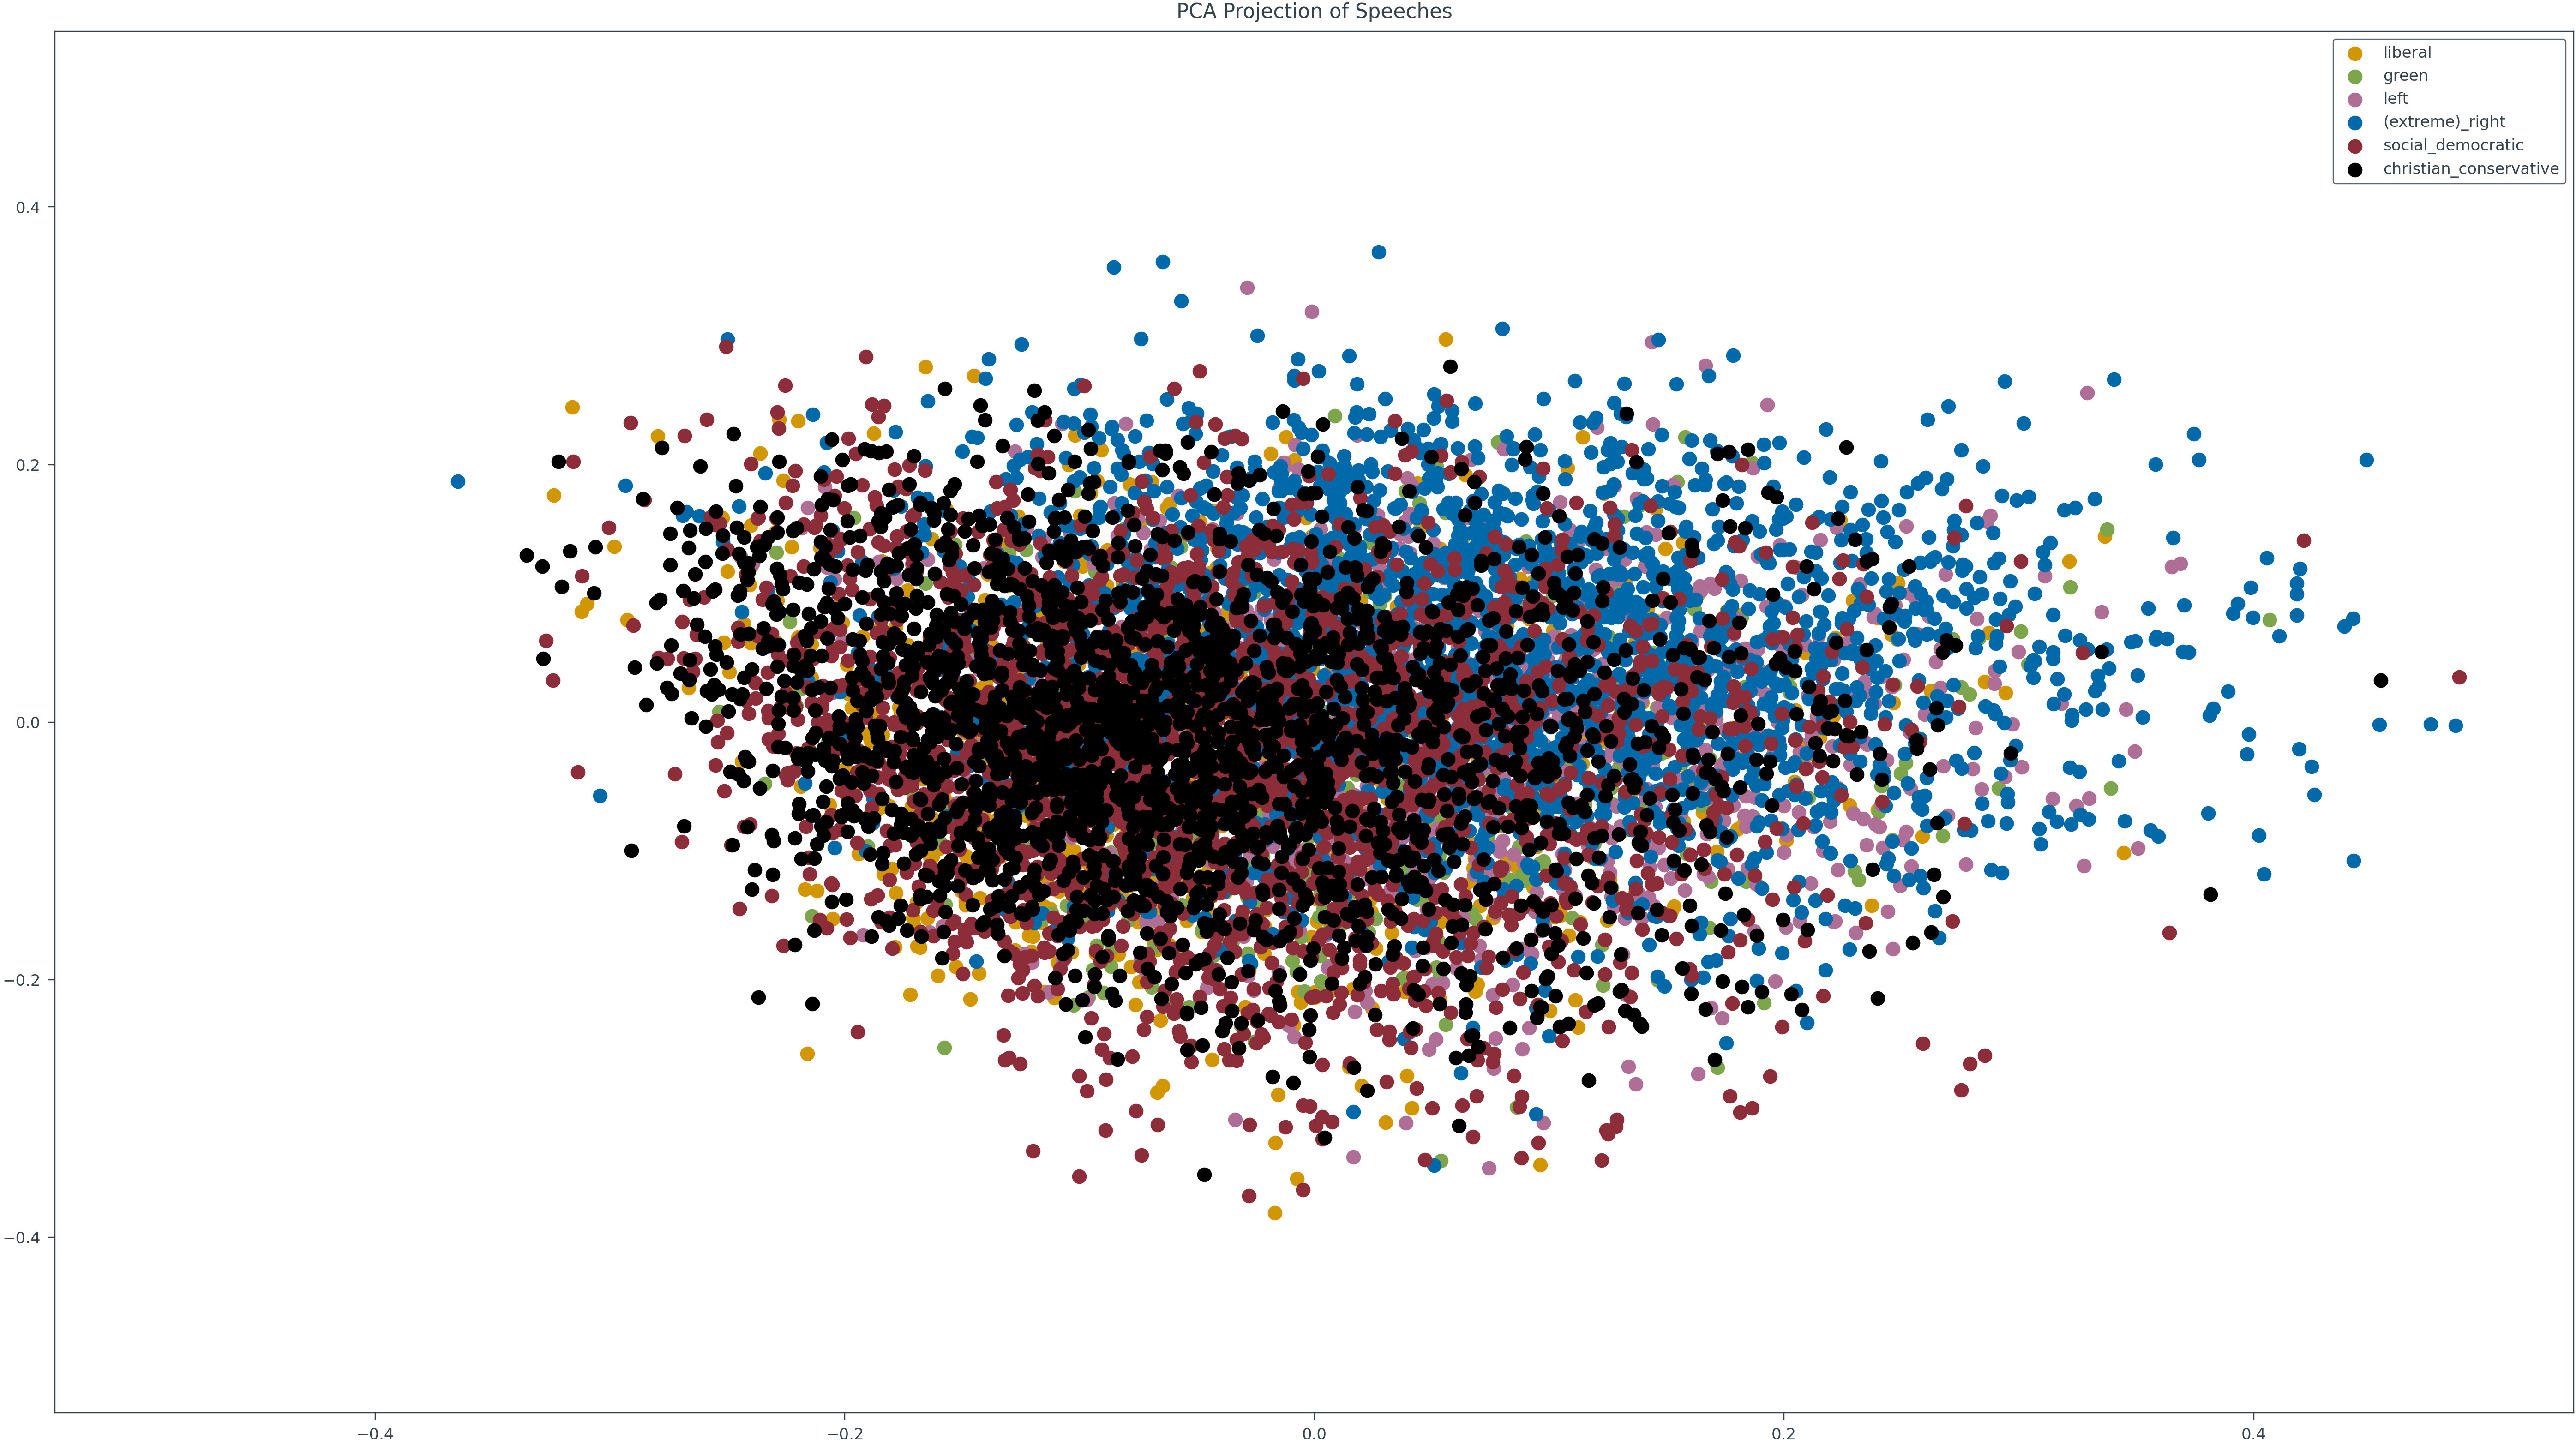

In [389]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
plt.title("PCA Projection of Speeches")

grt = np.abs(reduced_embeddings).max() * 1.1

ax.set_xlim(-grt, grt)
ax.set_ylim(-grt, grt)
scale = grt * 2


for party in df["block"].unique():
    party_mask = df["block"] == party
    party_embeddings = reduced_embeddings[party_mask]
    
    plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=COLOR_MAPS['block'][party], label=party)

ax.legend()

In [390]:
axis_labels_0 = closest_words_for_pc(2, pca, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(5, pca, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [391]:
display_axis_semantics([axis_labels_0, axis_labels_1])

In [393]:
neg_0, pos_0, neg_1, pos_1 = get_extreme_example_texts(df, reduced_embeddings / np.linalg.vector_norm(reduced_embeddings, ord=2, axis=1, keepdims=True))

In [394]:
(sum([label[0] in neg_1  for label in axis_labels_1[0]]), 
sum([label[0] in pos_1  for label in axis_labels_1[1]]), 
sum([label[0] in neg_0  for label in axis_labels_0[0]]),
sum([label[0] in pos_0  for label in axis_labels_0[1]]))

(1, 0, 0, 1)

In [395]:
print(textwrap.fill(pos_0))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_0[1]])))

Mr. President, twenty-four humanitarian aid workers on the island of
Lesbos accused of facilitating illegal immigration into Europe, a case
that a study by this Parliament described as the biggest case of
criminalization in Europe and for which the Office of the United
Nations High Commissioner for Human Rights called for the charges to
be dropped. And this is not the only case, unfortunately. Now we see
how the hard-right Italian Government is trying to obstruct, with this
decree, the activities of NGOs helping at sea. It is not about
regulating anything, but rather about making their work more difficult
and complicating it. And we also see that other Governments, moreover,
are practicing hot pushbacks, forced returns. We have seen it in
Greece, we have seen it in Croatia, we see it in Poland. Therefore,
Madam Commissioner, the Commission must act. European Union Law is
being violated by these authorities and by these Governments, both in
the criminalization of NGOs — which is a rule 

In [396]:
print(textwrap.fill(neg_0))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_0[0]])))

In light of the current deteriorating situation of migrants and asylum
seekers, particularly due to the uncoordinated response by European
countries, which makes such emergency support all the more necessary
and urgent and the need to show solidarity with the Member States
facing such an emergency situation on their territory, I welcome the
commission proposal and voted in favour of the draft Amending Budget
No 1/ 2016: New instrument to provide emergency support within the
Union.
Closest Words:
eurointegration, europeanorganized, europeancoordinated, eurocentric,
eurosur, eurostat, eurodistrict, eurodag, eurogroup, euafghanistan,
eucoordinated, eurodelegation, eurobonds, europols, europa,
eurobarometer, eurozone, eurocorps, europeanlevel, euroturkish


In [286]:
print(textwrap.fill(pos_1))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_1[1]])))

Welcome, Mr. Muscat, you have shown that a small island is not afraid
of great responsibility. Malta has managed the general agreement of
twenty States supporting the creation of the European Public
Prosecutor's Office, which its Government, however, does not defend,
and that is very commendable. He has also managed the agreement on the
proposal for a Directive on the fight against money laundering,
although the text was not very ambitious either. But Italy is
threatening these days to close its ports to the arrival of thousands
and thousands of people from Libya and Austria is threatening to put
soldiers on its borders with Italy while the majority of the Member
States put themselves in profile and, yes, the parliamentarians surely
too , on some occasions, we put ourselves in profile, Mr Juncker.
France and Germany have promised Italy and Greece that they will
increase relocation, but this increasingly sounds like words to buy
time. The migration and humanitarian crisis, unprecedented

In [397]:
print(textwrap.fill(neg_1))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_1[0]])))

Our European Union urgently needs to better control its external
borders. To do this, I believe it is necessary that we give Frontex
more opportunities and more powers. Together with these powers, more
obligations will of course follow for this organization. For example,
we in the European Parliament want an individual complaints mechanism
to be developed. This individual complaints procedure should make it
possible for refugees to report any human rights violations that have
occurred during Frontex operations or in cooperation with third
countries. After all, it is crucial that human rights are protected.
That is why I voted in favor of this special report.
Closest Words:
humanrightscompliant, humanrightsdriven, chairwoman, rightsrespecting,
dignities, präsidentin, congresswomen, rightsrights, womenrefugees,
woman, womens, dignity, women, inhumanity, rights, présidente,
genderequality, feminist, minorswomen, presidenta
